In [1]:
from skimage.measure import block_reduce
import numpy as np

import logging

from utils import logging as lg
lg.set_logging(logging.ERROR)
from model import provider, heatmap_evaluation
import matplotlib.pyplot as plt
import config
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

In [2]:
from utils import data_provider

In [3]:
dataset_loader = data_provider.DatasetLoader(data_dir='../data')

In [4]:
def model_path(network, dataset, seq):
    return '../final-models/%s-%s-seq-%d' % (network, dataset, seq)

In [5]:
def get_data_for_class(data_name, class_idx, no=16, seed=2):
    np.random.seed(seed)

    data = dataset_loader.load(data_name)
    indices = np.argmax(data.test2d.y, axis=1) == class_idx
    if no:
        s = np.random.choice(np.sum(indices), size=no, replace=False)
        return data.test2d.x[indices,:,:][s, :, :], data.test2d.y[indices,:][s, :]
    else:
        return data.test2d.x[indices,:,:], data.test2d.y[indices,:]

# Plot digit

In [8]:
mnist_1 = get_data_for_class('mnist', 1)

In [9]:
mnist_1_all = get_data_for_class('mnist', 1, no=None)
fmnist_1_all = get_data_for_class('fashion-mnist', 1, no=None)

In [10]:
mnist_1[0].shape
mnist_1_all[0].shape

(1135, 28, 28)

In [32]:
def plot_digits(data, title="", show_title=False):
    plt.figure(figsize=(16,2))
    for i in range(data.shape[0]):
        plt.subplot(1,16, i+1)
        plt.imshow(data[i,:,:], cmap='gray')
        plt.xticks([])
        plt.yticks([])
    if show_title:
        plt.suptitle(title)
    plt.show()

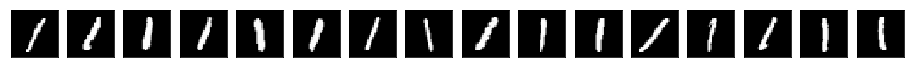

In [35]:
plot_digits(mnist_1[0], title="MNIST Class 1")

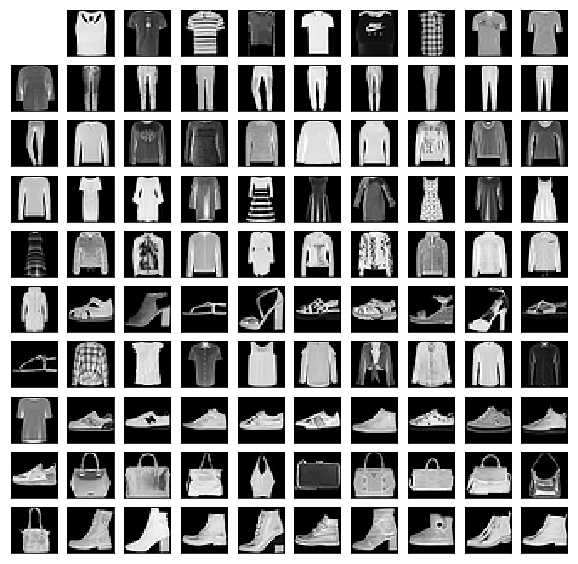

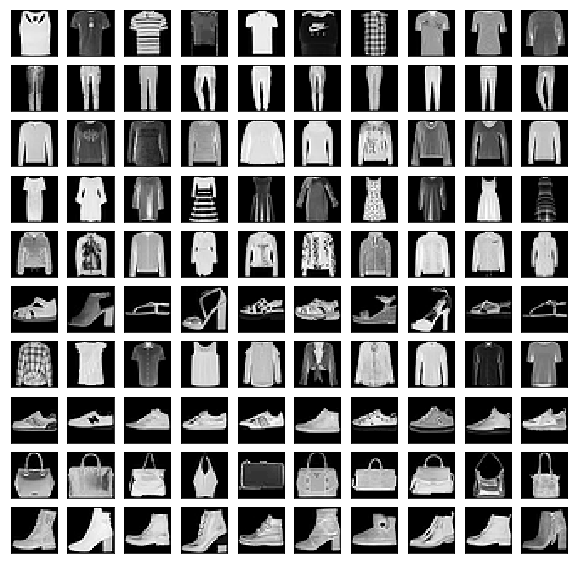

In [48]:
def plot_digits_all_class(dataset, title="", show_title=False):
    plt.figure(figsize=(10,10))
    count = 0
    for k in range(10):
        data = get_data_for_class('fashion-mnist', k, no=10)[0]
        for i in range(data.shape[0]):
            plt.subplot(10,10, count+1)
            plt.imshow(data[i,:,:], cmap='gray')
            plt.xticks([])
            plt.yticks([])
            count = count + 1
    if show_title:
        plt.suptitle(title)
    plt.show()
plot_digits_all_class('fashion-mnist')

AttributeError: 'tuple' object has no attribute 'shape'

In [11]:
fmnist_1 = get_data_for_class('fashion-mnist', 1)
fmnist_1_all = get_data_for_class('fashion-mnist', 1, no=None)

fmnist_anker_boots = get_data_for_class('fashion-mnist', 9, seed=7)
fmnist_anker_boots_all = get_data_for_class('fashion-mnist', 9, no=None)

In [12]:
fmnist_1_all.shape

AttributeError: 'tuple' object has no attribute 'shape'

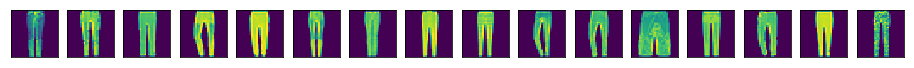

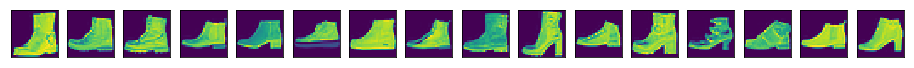

In [30]:
plot_digits(fmnist_1, 'Fashion MNIST-1')
plot_digits(fmnist_anker_boots, 'Fashion MNIST-9')


In [31]:
def plot_relevance(network, seq, dataset_name, data, method='lrp_deep_taylor'):
    path = model_path(network, dataset_name, seq)
    m = provider.load(path)
    _, heatmaps = getattr(m, 'rel_%s' % method)(data)
    plot_digits(heatmaps, title='%s : %s' % (method, m._.experiment_name), show_title=True)

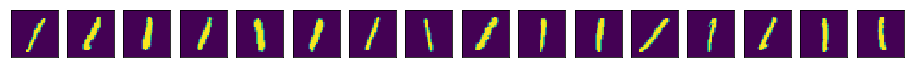

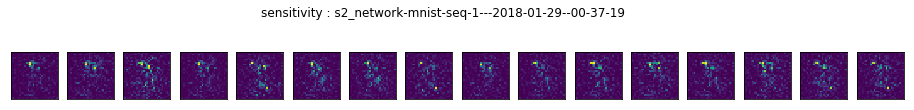

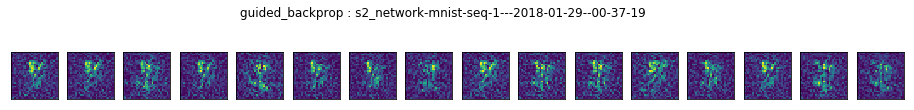

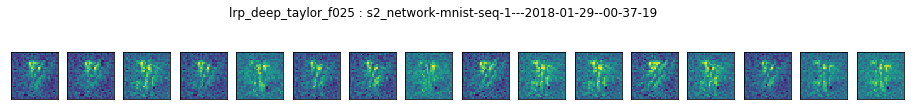

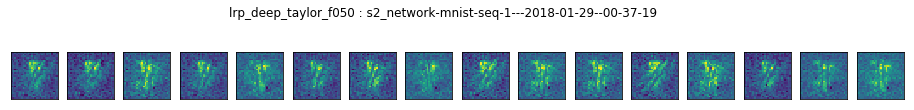

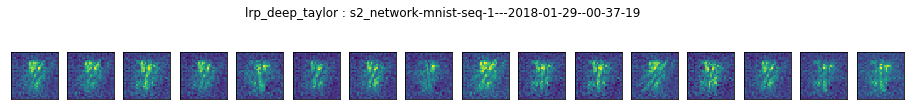

In [32]:
def plot_relevance_all(network, seq, dataset, data_obj):
    plot_digits(data_obj)
    for m in ['sensitivity', 'guided_backprop', 'lrp_deep_taylor_f025', 'lrp_deep_taylor_f050', 'lrp_deep_taylor']:
        plot_relevance(network, seq, dataset, data_obj, method=m)

plot_relevance_all('s2', 1, 'mnist', mnist_1)

## Shallow

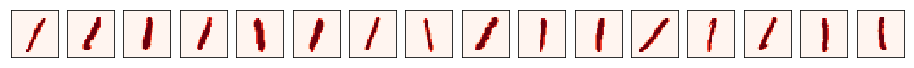

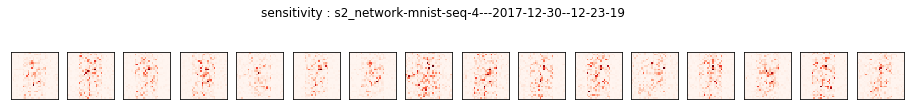

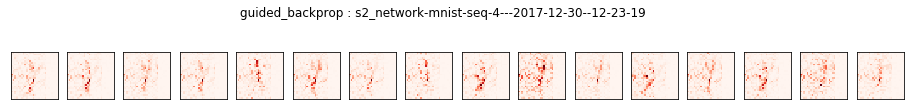

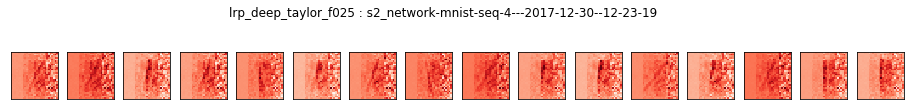

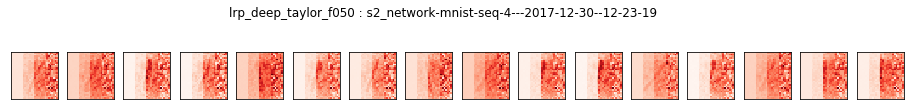

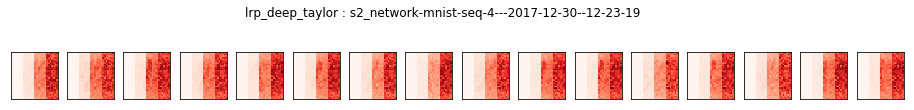

In [42]:
plot_relevance_all('s2', 4, 'mnist', mnist_1)

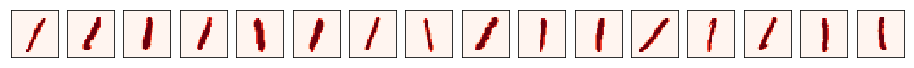

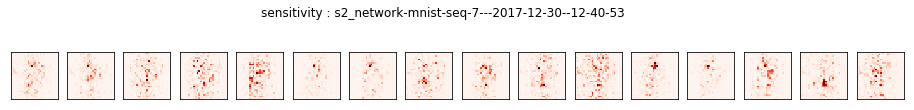

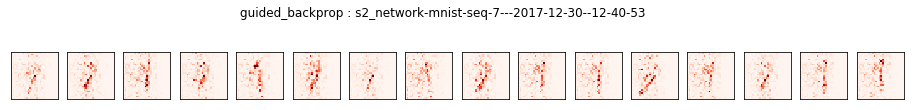

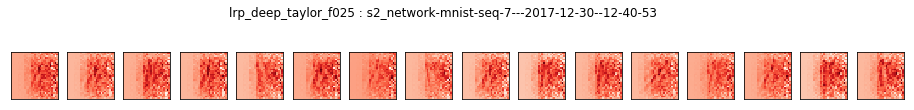

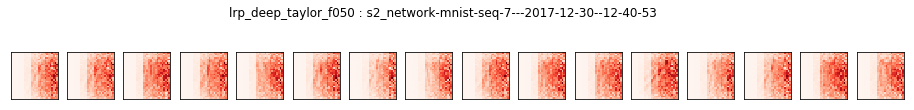

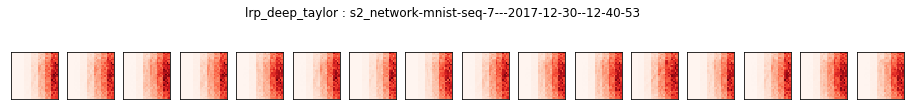

In [89]:
plot_relevance_all('s2', 7, 'mnist', mnist_1)

## Deep

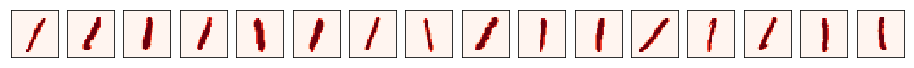

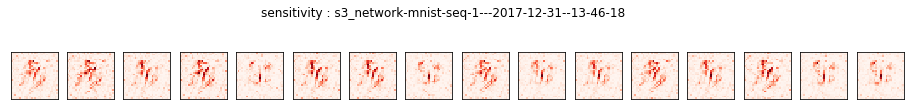

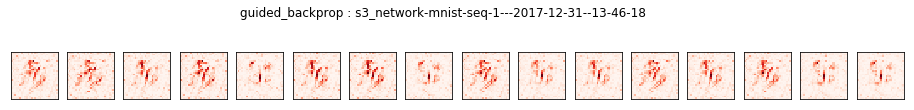

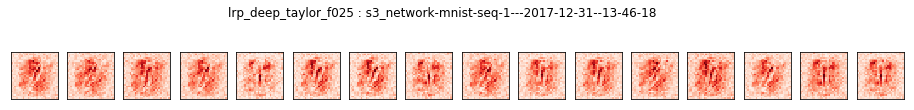

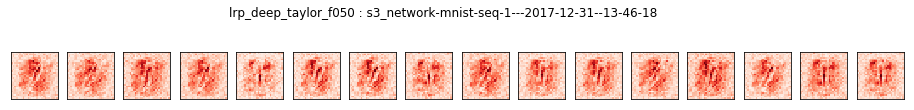

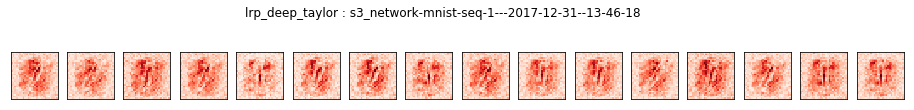

In [16]:
plot_relevance_all('s3', 1, 'mnist', mnist_1)

## DeepV2

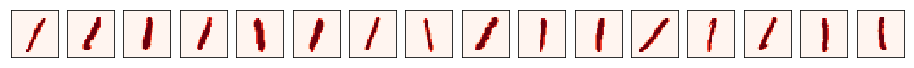

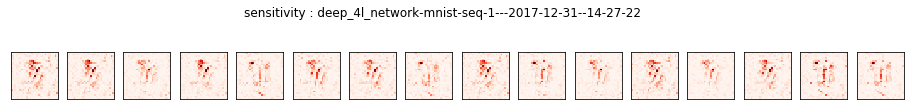

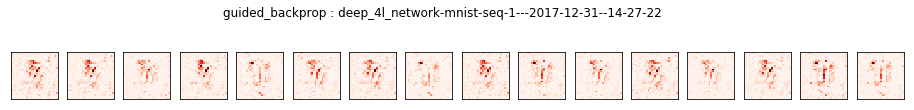

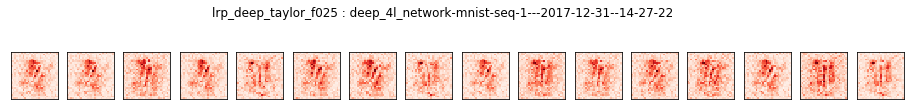

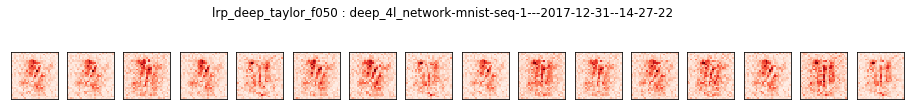

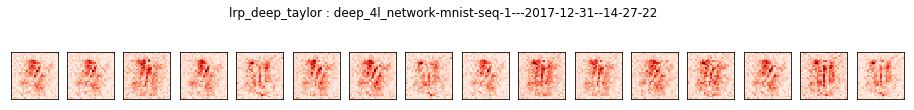

In [17]:
plot_relevance_all('deep_4l', 1, 'mnist', mnist_1)

## ConvDeep

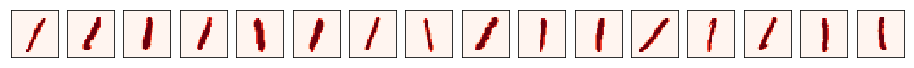

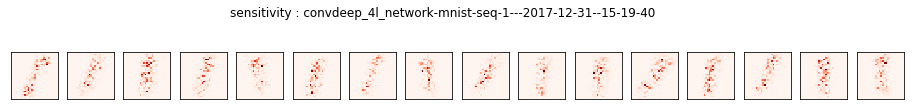

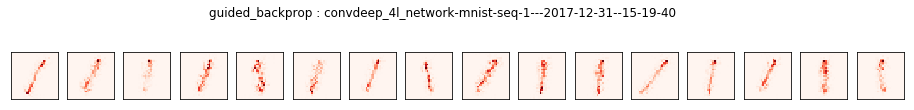

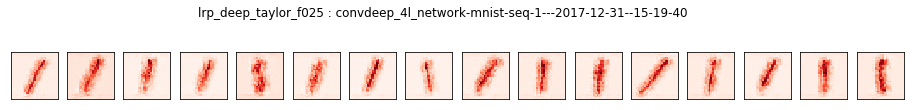

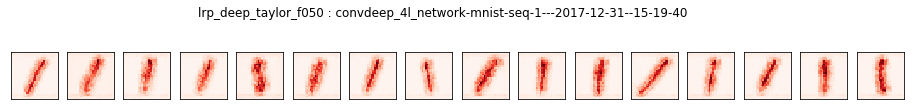

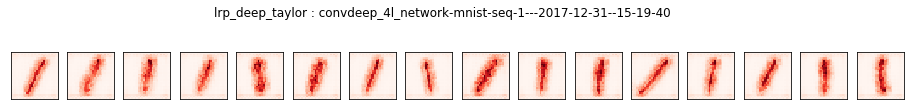

In [18]:
plot_relevance_all('convdeep_4l', 1, 'mnist', mnist_1)

## FashionMNIST

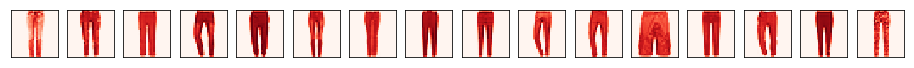

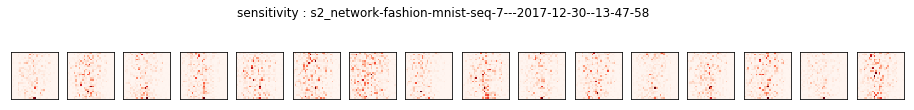

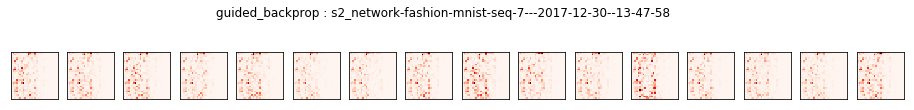

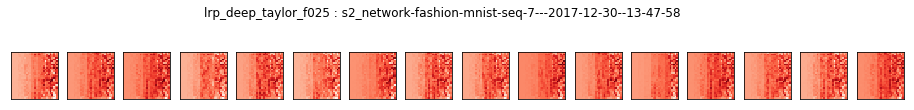

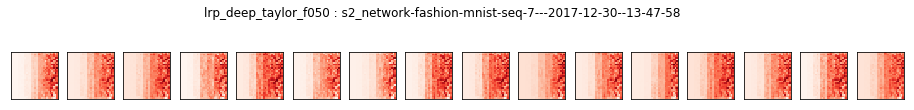

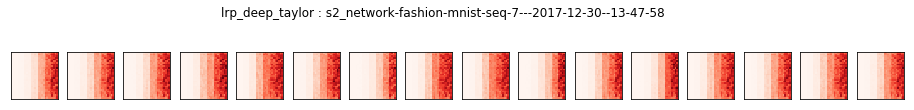

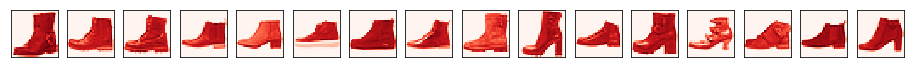

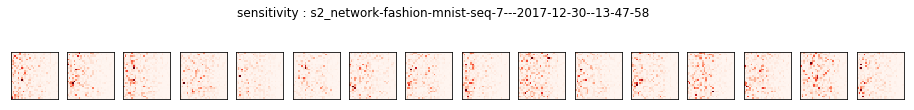

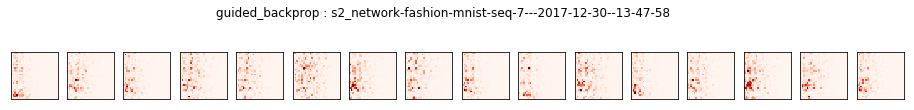

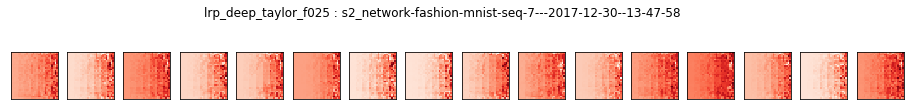

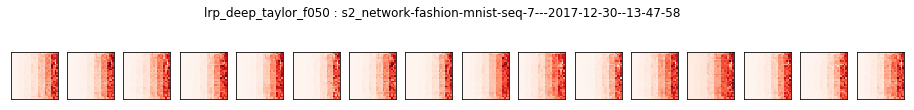

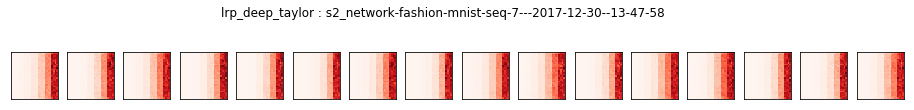

In [19]:
plot_relevance_all('s2', 7, 'fashion-mnist', fmnist_1)
plot_relevance_all('s2', 7, 'fashion-mnist', fmnist_anker_boots)

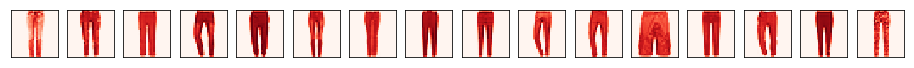

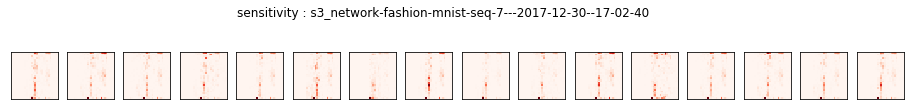

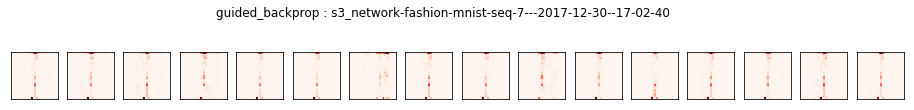

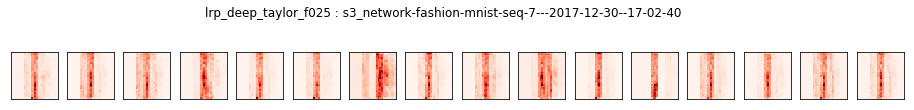

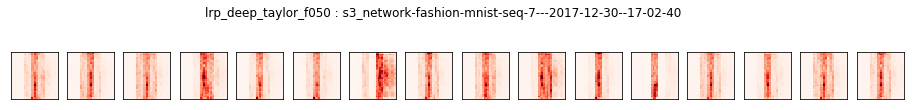

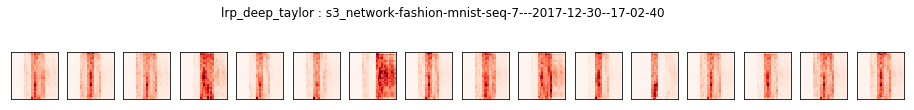

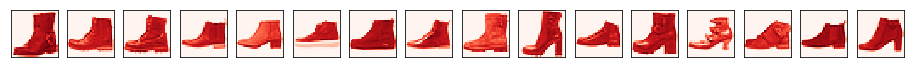

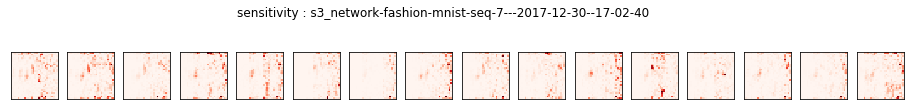

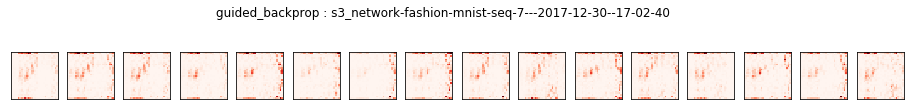

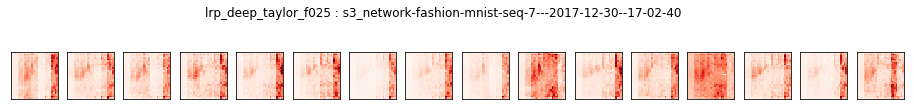

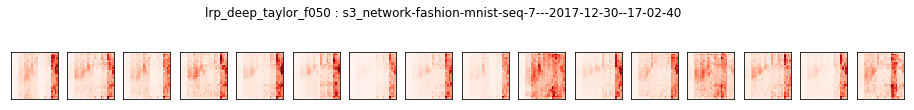

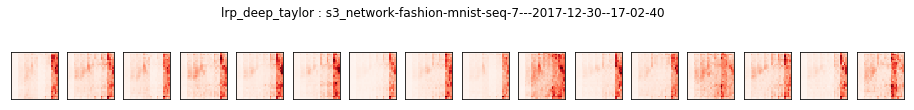

In [20]:
plot_relevance_all('s3', 7, 'fashion-mnist', fmnist_1)
plot_relevance_all('s3', 7, 'fashion-mnist', fmnist_anker_boots)

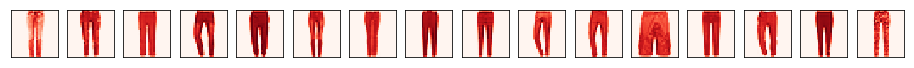

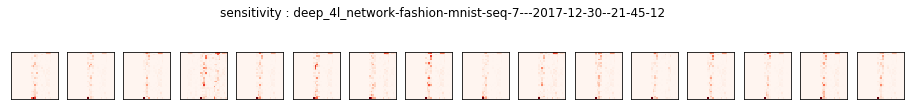

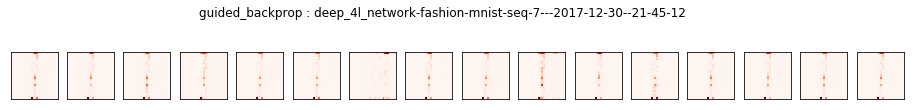

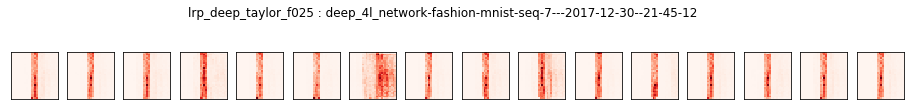

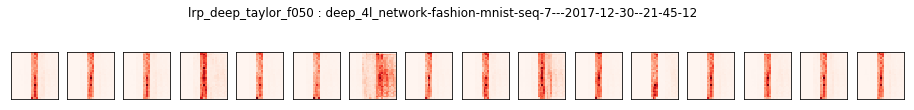

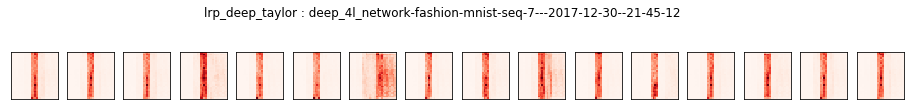

In [21]:
plot_relevance_all('deep_4l', 7, 'fashion-mnist', fmnist_1)

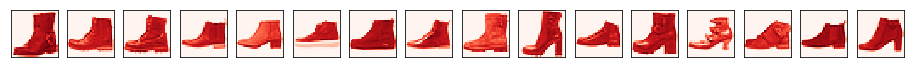

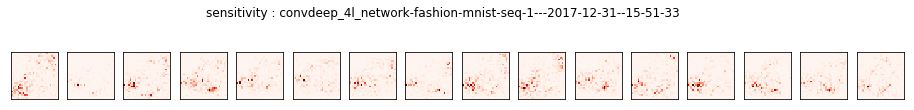

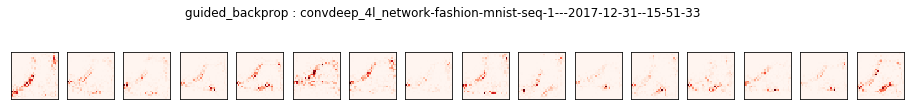

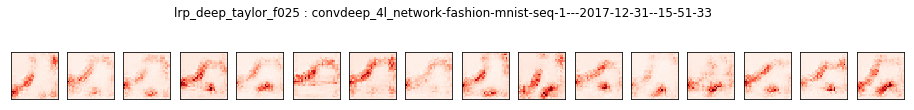

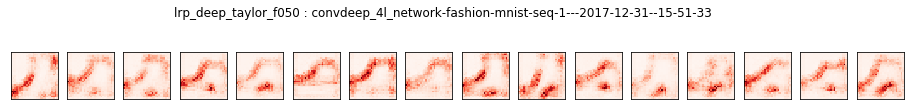

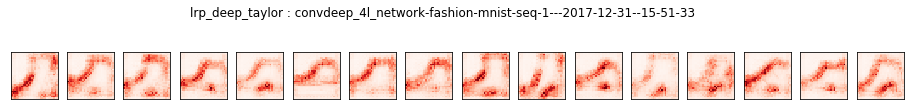

In [41]:
plot_relevance_all('convdeep_4l', 1, 'fashion-mnist', fmnist_anker_boots)

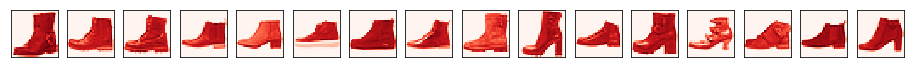

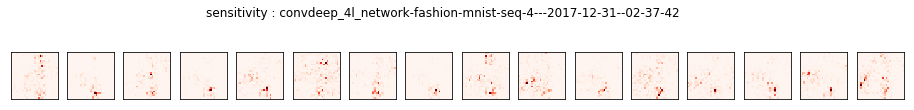

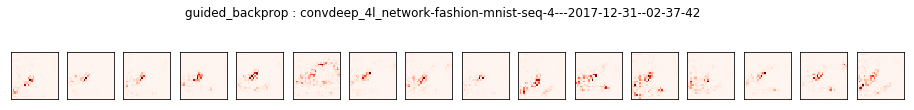

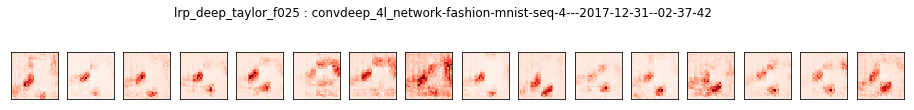

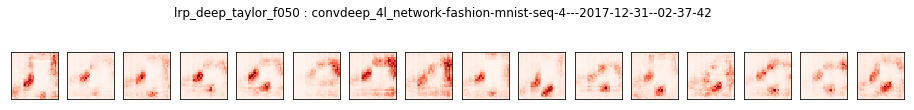

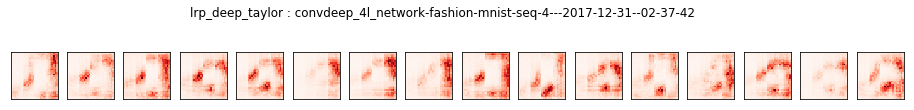

In [40]:
plot_relevance_all('convdeep_4l', 4, 'fashion-mnist', fmnist_anker_boots)

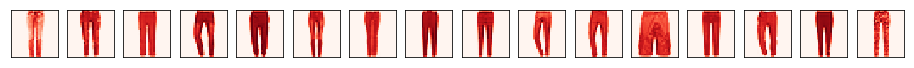

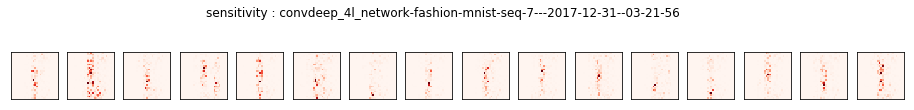

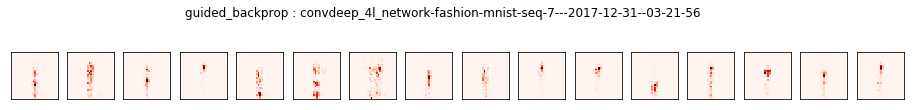

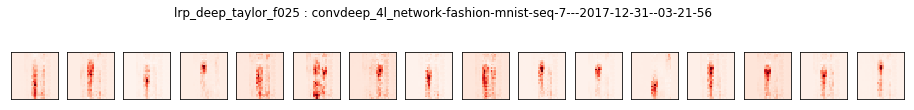

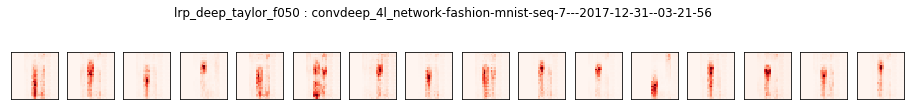

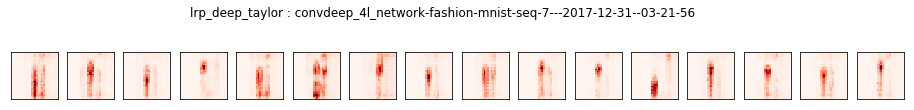

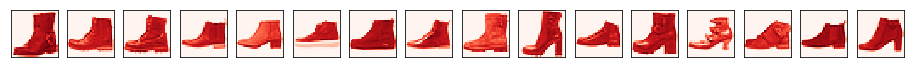

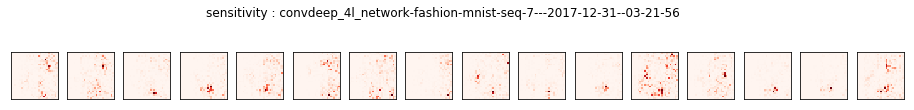

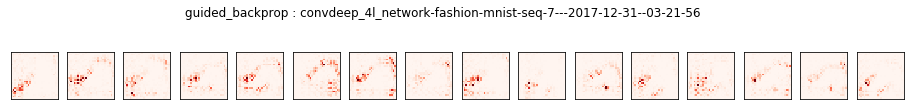

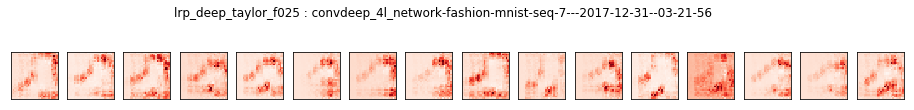

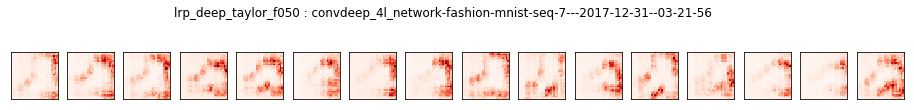

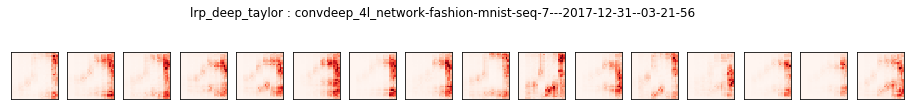

In [22]:
plot_relevance_all('convdeep_4l', 7, 'fashion-mnist', fmnist_1)
plot_relevance_all('convdeep_4l', 7, 'fashion-mnist', fmnist_anker_boots)

# Plot distribution

In [18]:
def compute_distribution(data, seq):
    dist = np.zeros(seq)

    dmin = np.min(data)
    dmax = np.max(data)
    normalized = (data - dmin)/(dmax-dmin)
    no_cols_feed = int(data.shape[2]/seq)
    xaxis = []
    for i in range(0, data.shape[2], no_cols_feed):
        st, end = i, i+no_cols_feed
        step = int(i/no_cols_feed)

        dist[step] = np.sum(normalized[:, :, st:end])
        
    return dist / np.sum(dist)

def compute_entropy_dist(data, seq):

    dmin = np.min(data)
    dmax = np.max(data)

    no_cols_feed = int(data.shape[2]/seq)
    xaxis = []
    entropies = np.zeros((data.shape[0], seq))
    for i in range(0, data.shape[2], no_cols_feed):
        st, end = i, i+no_cols_feed
        
        step = int(i/no_cols_feed)

        count, _ = np.histogram(data[:, :, st:end], bins=100, range=(dmin,dmax))
        
        prob = count / np.sum(count)
        indices = np.where(prob > 0)
        
        prob = prob[indices]
        
        lprob = np.log2(prob)
        entropies[:, step] = -np.sum(prob*lprob)
        
    if seq > 1:
        sum_ent = np.sum(entropies, axis=1)
        normed_entropies = entropies / sum_ent.reshape(-1,1)
        agg_entropies = np.sum(normed_entropies, axis=0)
        dist_ent = agg_entropies / np.sum(agg_entropies)

    else:
        print('not noramlize entropy because seq=%d' % seq)
        normed_entropies = entropies
        dist_ent = np.mean(normed_entropies)
        print('%f' % dist_ent)

    return dist_ent

In [17]:
def plot_dist(data, seq, title=""):
    dist = np.zeros(seq)

    dmin = np.min(data)
    dmax = np.max(data)
    normalized = (data - dmin)/(dmax-dmin)
    no_cols_feed = int(data.shape[2]/seq)
    xaxis = []
    for i in range(0, data.shape[2], no_cols_feed):
        st, end = i, i+no_cols_feed
        step = int(i/no_cols_feed)

        dist[step] = np.sum(normalized[:, :, st:end])

        xaxis.append('%d:%d' %(st+1, end))
    plt.bar(range(seq), dist / np.sum(dist), 0.5, color='r')
#     plt.xticks(range(seq), xaxis)
    plt.xlabel('Column $i$th')
    plt.title(title)
    plt.show()
plot_dist(mnist_1, 7)

ValueError: could not broadcast input array from shape (16,28,28) into shape (16)

In [35]:
def plot_rel_dist(network, data, dataset_name, seq):
    path = model_path(network, dataset_name, seq)
    m = provider.load(path)
    _, heatmaps = m.rel_lrp_deep_taylor(data)
    plot_dist(heatmaps, seq, title='Rel Dist of %s' % m._.experiment_name)

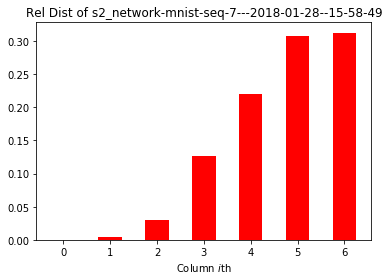

In [36]:
plot_rel_dist('s2', mnist_1, 'mnist', 7)

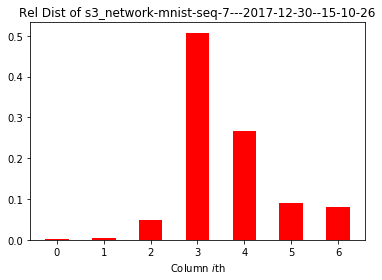

In [27]:
plot_rel_dist('s3', mnist_1, 'mnist', 7)

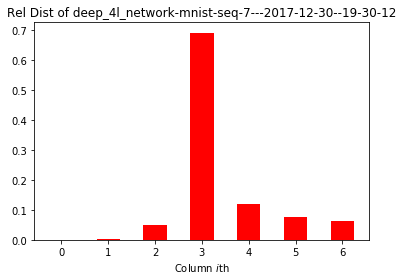

In [28]:
plot_rel_dist('deep_4l', mnist_1, 'mnist', 7)

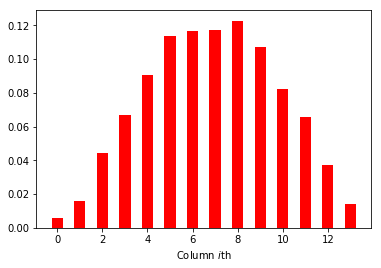

In [29]:
plot_dist(dataset['fashion-mnist'].test2d.x, 14)

# Plot dist for report

(1135, 28, 28)


/Users/heytitle/projects/heatmapping-tutorial/src/model/components/layer.py:34: RuntimeWarning: divide by zero encountered in log
  self.b = tf.Variable(tf.ones(dims[-1]) * float(np.log(np.exp(DEFAULT_BIAS_VALUE)-1)), name=b_name)


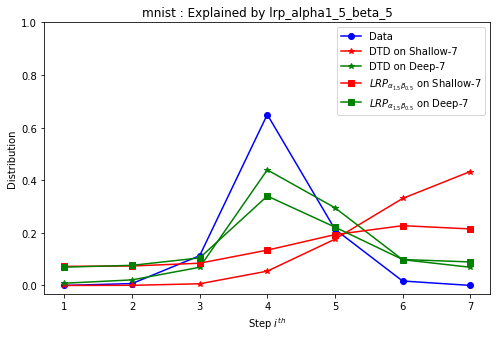

In [45]:
def plot_distributions(networks, dataset_name, data, seq, methods=['sensitivity'], markers=None,
                       colors=['r'],
                       data_label="Data", dist_entropy=False):
    plt.figure(figsize=(8,5))
    
    if dist_entropy:
        dist_data = compute_entropy_dist(data[0], seq)
    else:
        dist_data = compute_distribution(data[0], seq)
    plt.plot(dist_data, 'b-', label=data_label, marker='o')
    print(data[0].shape)
    if markers is None:
        markers = ['.']*len(methods)
    for idx, method in enumerate(methods):
        for model_idx, i in enumerate(networks):
            path = model_path(i, dataset_name, seq)
            m = provider.load(path)
            _, heatmaps = getattr(m, 'rel_%s' % method)(data[0], data[1] )
            if dist_entropy:
                dist_hm = compute_entropy_dist(heatmaps, seq)
            else:
                dist_hm = compute_distribution(heatmaps, seq)
            plt.plot(dist_hm, colors[model_idx], label="%s on %s-%d" % (config.METHOD_ABBREVATIONS[method],
                                                  config.architecture_name(i),seq), marker=markers[idx])
    if dist_entropy:
        plt.ylabel('Relative Entropy Distribution')
    else:
        plt.ylabel('Distribution')

    plt.xlabel('Step $i^{th}$')
    plt.yticks(np.arange(0,1.1, 0.2))

    plt.xticks(range(seq), range(1, seq+1))
    plt.title('%s : Explained by %s' % (dataset_name, method))
    plt.legend()
    plt.savefig('dist-%s-%d.svg' % (dataset_name, seq))
    plt.show()
    
# def plot_dist_with_methods(networks, dataset_name, data, seq, data_label="Data", dist_entropy=False):
#     for m in ['sensitivity', 'guided_backprop', 'lrp_deep_taylor']:
#         plot_distributions(networks, dataset_name, data, seq, method=m, data_label=data_label, dist_entropy=dist_entropy)

plot_distributions(['shallow', 'deep'],'mnist', mnist_1_all, 7, 
                   methods=['lrp_deep_taylor', 'lrp_alpha1_5_beta_5'],
                   markers=['*', 's'], colors=['r', 'g'],
                   data_label="Data", dist_entropy=False) 

(1000, 28, 28)


/Users/heytitle/projects/heatmapping-tutorial/src/model/components/layer.py:34: RuntimeWarning: divide by zero encountered in log
  self.b = tf.Variable(tf.ones(dims[-1]) * float(np.log(np.exp(DEFAULT_BIAS_VALUE)-1)), name=b_name)


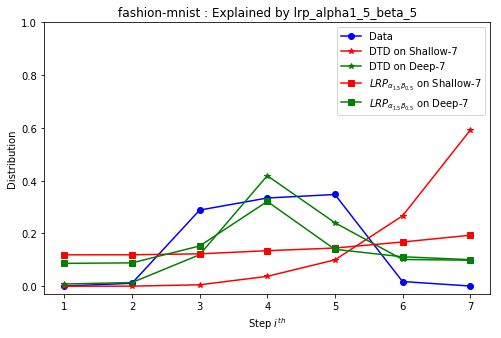

In [46]:
plot_distributions(['shallow', 'deep'],'fashion-mnist', fmnist_1_all, 7, 
                   methods=['lrp_deep_taylor', 'lrp_alpha1_5_beta_5'],
                   markers=['*', 's'], colors=['r', 'g'],
                   data_label="Data", dist_entropy=False)

/Users/heytitle/projects/heatmapping-tutorial/src/model/components/layer.py:34: RuntimeWarning: divide by zero encountered in log
  self.b = tf.Variable(tf.ones(dims[-1]) * float(np.log(np.exp(DEFAULT_BIAS_VALUE)-1)), name=b_name)


(1000, 28, 28)
(1000, 28, 28)


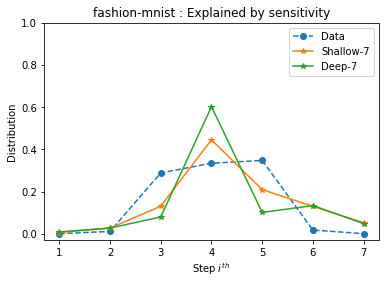

(1000, 28, 28)
(1000, 28, 28)


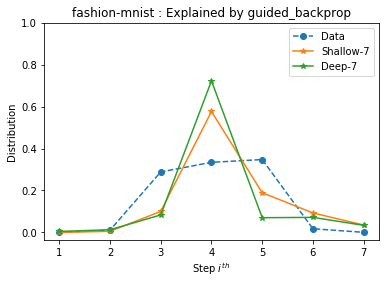

(1000, 28, 28)
(1000, 28, 28)


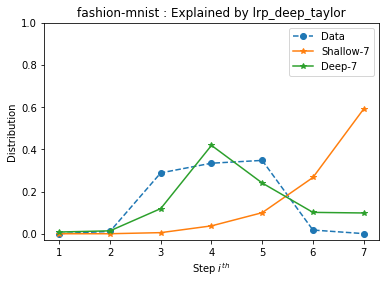

In [31]:
plot_dist_with_methods(['shallow', 'deep'], 'fashion-mnist', fmnist_1_all, 7, data_label="Data", dist_entropy=False)        

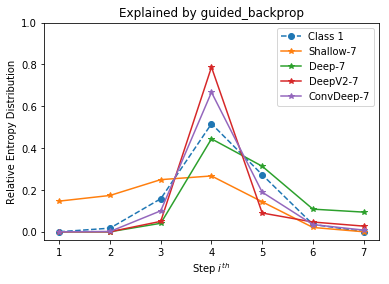

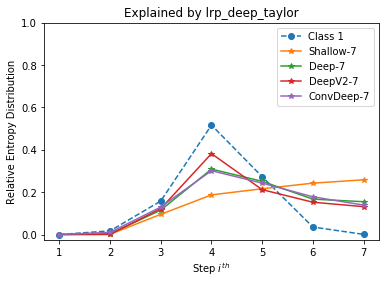

In [87]:
plot_dist_with_methods(['s2', 's3', 'deep_4l', 'convdeep_4l'], 'mnist', mnist_1_all, 7, data_label="Class 1", dist_entropy=True)

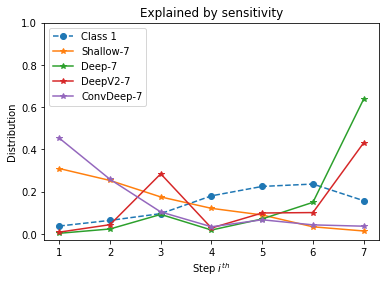

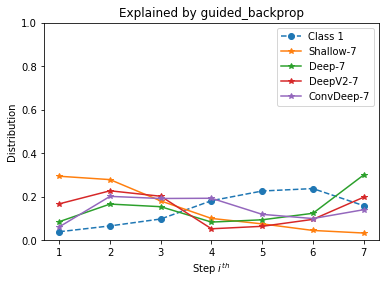

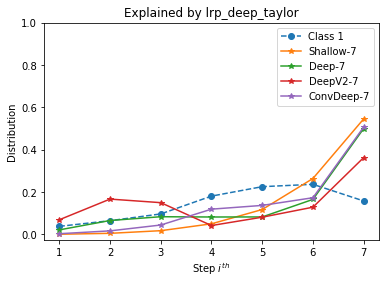

In [37]:
plot_dist_with_methods(['s2', 's3','deep_4l', 'convdeep_4l'], 'fashion-mnist', fmnist_anker_boots, 7, data_label="Class 1", dist_entropy=False)

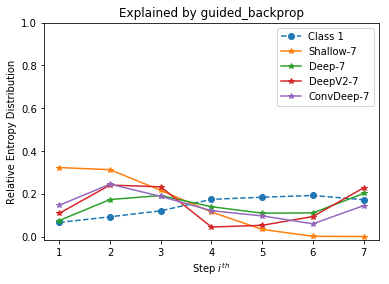

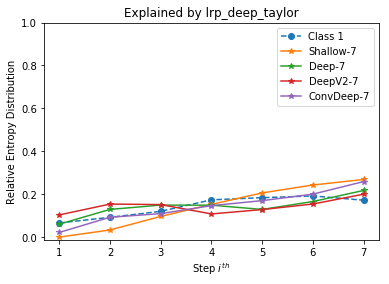

In [88]:
plot_dist_with_methods(['s2', 's3', 'deep_4l', 'convdeep_4l'], 'fashion-mnist', fmnist_anker_boots, 7, data_label="Class 1", dist_entropy=True)